In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table

from kpf_etc.etc import kpf_photon_noise_estimate, kpf_etc_rv, kpf_etc_snr

In [2]:
tsm_targets = Table(np.genfromtxt('Tom/RVvaluesByTSM_onlyPCs.txt', usecols=np.arange(20), names=True, dtype=None, encoding=None))
esm_targets = Table(np.genfromtxt('Tom/RVvaluesByESM_onlyPCs.txt', usecols=np.arange(20), names=True, dtype=None, encoding=None))

In [3]:
tsm_targets.columns

<TableColumns names=('Target','TICID','RA','Dec','Vmag','Imag','Jmag','Hmag','Kmag','TSM','Kms','Pd','TeffK','loggCGS','RsRS','MsMS','MpME','RpRE','TeqK','Priority')>

In [4]:
from astropy.coordinates import SkyCoord
import astropy.units as u
tsm_coords = SkyCoord(ra=tsm_targets['RA'], dec=tsm_targets['Dec'])
esm_coords = SkyCoord(ra=esm_targets['RA'], dec=esm_targets['Dec'])

#### select targets with small radii located in the Northern hemisphere+ecliptic:

In [5]:
tsm_mask = (tsm_coords.dec >= -30 * u.deg) & (tsm_coords.dec <= 70 * u.deg) & (tsm_targets['RpRE'] <= 3.)
esm_mask = (esm_coords.dec >= -30 * u.deg) & (esm_coords.dec <= 70 * u.deg) & (esm_targets['RpRE'] <= 3.)

In [6]:
tsm_targets = tsm_targets[tsm_mask]
esm_targets = esm_targets[esm_mask]

#### calculate the expected exposure times:

I know there's a flux-magnitude-SNR relationship that should be simple to derive, but I hate deriving things so instead we're gonna brute-force extrapolate the exposure time calculator to higher magnitudes with linear regression.

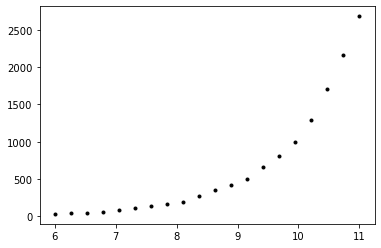

In [7]:
vmags = np.linspace(6,11,20)
exp_times = np.zeros_like(vmags)
for i,vmag in enumerate(vmags):
    exp_times[i] = kpf_etc_rv(5800., vmag, 0.3)
plt.plot(vmags, exp_times, 'k.');

LinregressResult(slope=0.38671550869732635, intercept=-0.8250533683587986, rvalue=0.9994204485140321, pvalue=6.989836083191708e-28, stderr=0.0031045966333153323)


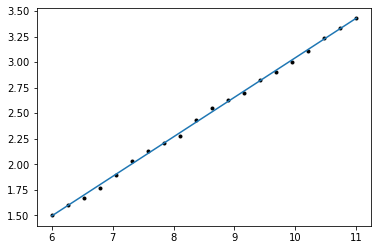

In [8]:
from scipy.stats import linregress
func = linregress(vmags, np.log10(exp_times))
print(func)
plt.plot(vmags, np.log10(exp_times), 'k.');
plt.plot(vmags, func.slope*vmags + func.intercept);

In [9]:
tsm_targets['exp_time'] = np.zeros_like(tsm_targets['Kms'])
for i,target in enumerate(tsm_targets):
    #sigma_rv_desired = target['Kms'] # m/s
    sigma_rv_desired = 0.5 # m/s
    try:
        exp_time = kpf_etc_rv(target['TeffK'], target['Vmag'], sigma_rv_desired)
    except ValueError:
        exp_time_V8 = kpf_etc_rv(target['TeffK'], 8., sigma_rv_desired)
        exp_time = exp_time_V8 / 10.**(func.slope * (8. - target['Vmag']))
    print('Vmag {0:04.1f}, Teff {1:4.0f} K, RV precision {2:05.2f} m/s = {3:.1f} s'.format(target['Vmag'], 
                                                                                target['TeffK'], 
                                                                                sigma_rv_desired,
                                                                                exp_time))
    tsm_targets['exp_time'][i] = exp_time

Vmag 10.1, Teff 4935 K, RV precision 00.50 m/s = 348.0 s
Vmag 09.7, Teff 4695 K, RV precision 00.50 m/s = 196.0 s
Vmag 12.3, Teff 3633 K, RV precision 00.50 m/s = 1146.0 s
Vmag 15.7, Teff 3333 K, RV precision 00.50 m/s = 13299.6 s
Vmag 10.9, Teff 4079 K, RV precision 00.50 m/s = 490.0 s
Vmag 06.9, Teff 6338 K, RV precision 00.50 m/s = 37.0 s
Vmag 08.6, Teff 5560 K, RV precision 00.50 m/s = 119.0 s
Vmag 08.6, Teff 5560 K, RV precision 00.50 m/s = 119.0 s
Vmag 12.5, Teff 3382 K, RV precision 00.50 m/s = 908.0 s
Vmag 09.4, Teff 5098 K, RV precision 00.50 m/s = 181.0 s
Vmag 10.2, Teff 4219 K, RV precision 00.50 m/s = 316.0 s
Vmag 12.7, Teff 3352 K, RV precision 00.50 m/s = 1011.0 s
Vmag 08.9, Teff 4406 K, RV precision 00.50 m/s = 97.0 s
Vmag 09.9, Teff 4946 K, RV precision 00.50 m/s = 277.0 s
Vmag 11.1, Teff 4635 K, RV precision 00.50 m/s = 693.0 s
Vmag 07.0, Teff 5470 K, RV precision 00.50 m/s = 26.0 s
Vmag 13.2, Teff 3621 K, RV precision 00.50 m/s = 2625.0 s
Vmag 08.4, Teff 5668 K, RV pr

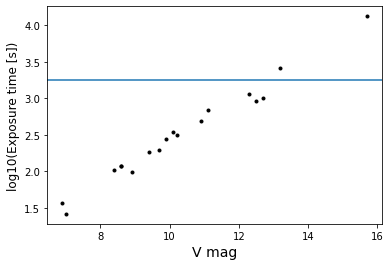

In [10]:
plt.plot(tsm_targets['Vmag'], np.log10(tsm_targets['exp_time']), 'k.')
plt.xlabel('V mag', fontsize=14)
plt.ylabel('log10(Exposure time [s])', fontsize=12)
plt.axhline(np.log10(60. * 30.));

We probably want to cut the three stars with V > 12.5, since those need in excess of 30 minutes per integration and they're also all M dwarfs, meaning that probably they can be observed more efficiently with MAROON-X or NEID (though M-X goes only to 920nm, NEID to 930nm, and KPF goes to 870nm, so maybe it's not that much of a difference?).

In terms of RV precision, the number of exposures $N$ we need to get 20% (5-sigma) mass precision is set by:
$$ \sqrt{N_{exp}} = \frac{5 \times \sigma_{RV}}{K} $$
see e.g. survey completeness fractions in Howard & Fulton (2016).

But this doesn't really work here because individual exposures are already at or above the required precision; instead we are limited by the coverage and the number/location of data points needed. We could maybe make up a lower limit threshold of 40 RVs per target??

In [11]:
tsm_targets['n_exp'] = np.maximum((5 * 0.5 / tsm_targets['Kms']) ** 2, np.zeros_like(tsm_targets['Kms']) + 40.) # if < 40, round it up to 40
exp_times_rounded_up = np.maximum(tsm_targets['exp_time'], np.zeros_like(tsm_targets['exp_time']) + 600.) # if < 10 min, round it up to 10 min
tsm_targets['total_time'] = tsm_targets['n_exp'] * exp_times_rounded_up

In [12]:
tsm_targets.sort('total_time')

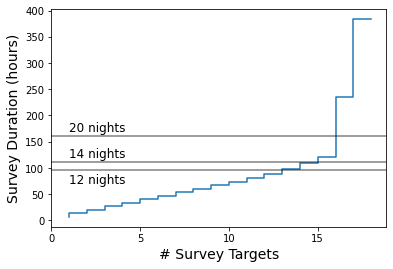

In [13]:
plt.step(np.arange(len(tsm_targets))+1, np.cumsum(tsm_targets['total_time'])/3600.)
plt.xticks([0,5,10,15])
plt.ylabel('Survey Duration (hours)', fontsize=14)
plt.xlabel('# Survey Targets', fontsize=14)
plt.axhline(8*12, c='k', alpha=0.5)
plt.text(1.,70,'12 nights', fontsize=12)
plt.axhline(8*14, c='k', alpha=0.5)
plt.text(1.,120,'14 nights', fontsize=12)
plt.axhline(160, c='k', alpha=0.5)
plt.text(1.,170,'20 nights', fontsize=12);

In [14]:
tsm_targets = tsm_targets[np.cumsum(tsm_targets['total_time'])/3600./8. <= 14.]

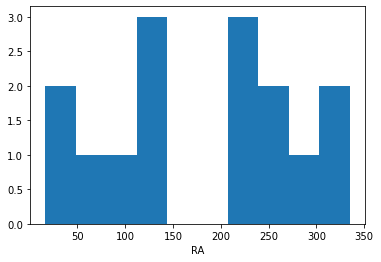

In [15]:
plt.hist(SkyCoord(ra=tsm_targets['RA'], dec=tsm_targets['Dec']).ra.to(u.deg).value)
plt.xlabel('RA');

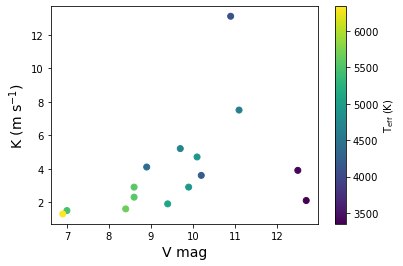

In [16]:
plt.scatter(tsm_targets['Vmag'], tsm_targets['Kms'], c=tsm_targets['TeffK'])
plt.xlabel('V mag', fontsize=14)
plt.ylabel(r'K (m s$^{-1}$)', fontsize=14)
plt.colorbar(label=r'T$_{\mathrm{eff}}$ (K)');

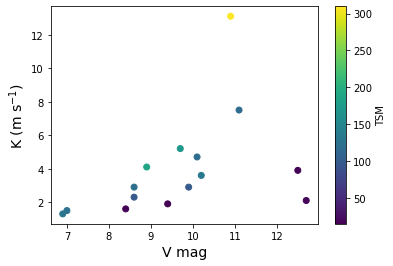

In [17]:
plt.scatter(tsm_targets['Vmag'], tsm_targets['Kms'], c=tsm_targets['TSM'])
plt.xlabel('V mag', fontsize=14)
plt.ylabel(r'K (m s$^{-1}$)', fontsize=14)
plt.colorbar(label=r'TSM');

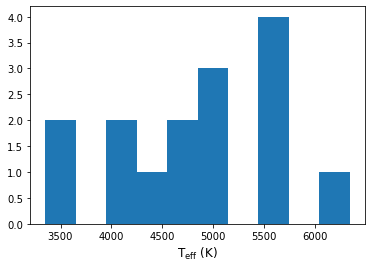

In [18]:
plt.hist(tsm_targets['TeffK'])
plt.xlabel(r'T$_{\mathrm{eff}}$ (K)', fontsize=12);

In [21]:
tsm_targets.write('kpf_targets.csv')